In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import scipy.signal as signal
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
import seaborn as sns

In [2]:
samitropTrue_directory_path = os.path.expanduser('~/project/data/samitropTrue')
ptbXLFalse_directory_path = os.path.expanduser('~/project/data/ptbxlFalse')

def get_record_paths(directory):
    """Get paths of all records in directory (without extension)"""
    record_paths = []
    for file in os.listdir(directory):
        if file.endswith('.hea'):
            # Remove .hea extension to get record name
            record_name = os.path.join(directory, file[:-4])
            record_paths.append(record_name)
    return record_paths

In [3]:
# Get record paths for both directories
samitrop_records = get_record_paths(samitropTrue_directory_path)
ptbxl_records = get_record_paths(ptbXLFalse_directory_path)

print(f"Number of True records: {len(samitrop_records)}")
print(f"Number of False records: {len(ptbxl_records)}")

Number of True records: 815
Number of False records: 21799


Processing 1 records:   0%|          | 0/815 [00:00<?, ?it/s]

Processing 0 records:   0%|          | 0/21799 [00:00<?, ?it/s]

Summary statistics by group (1=True, 0=False):


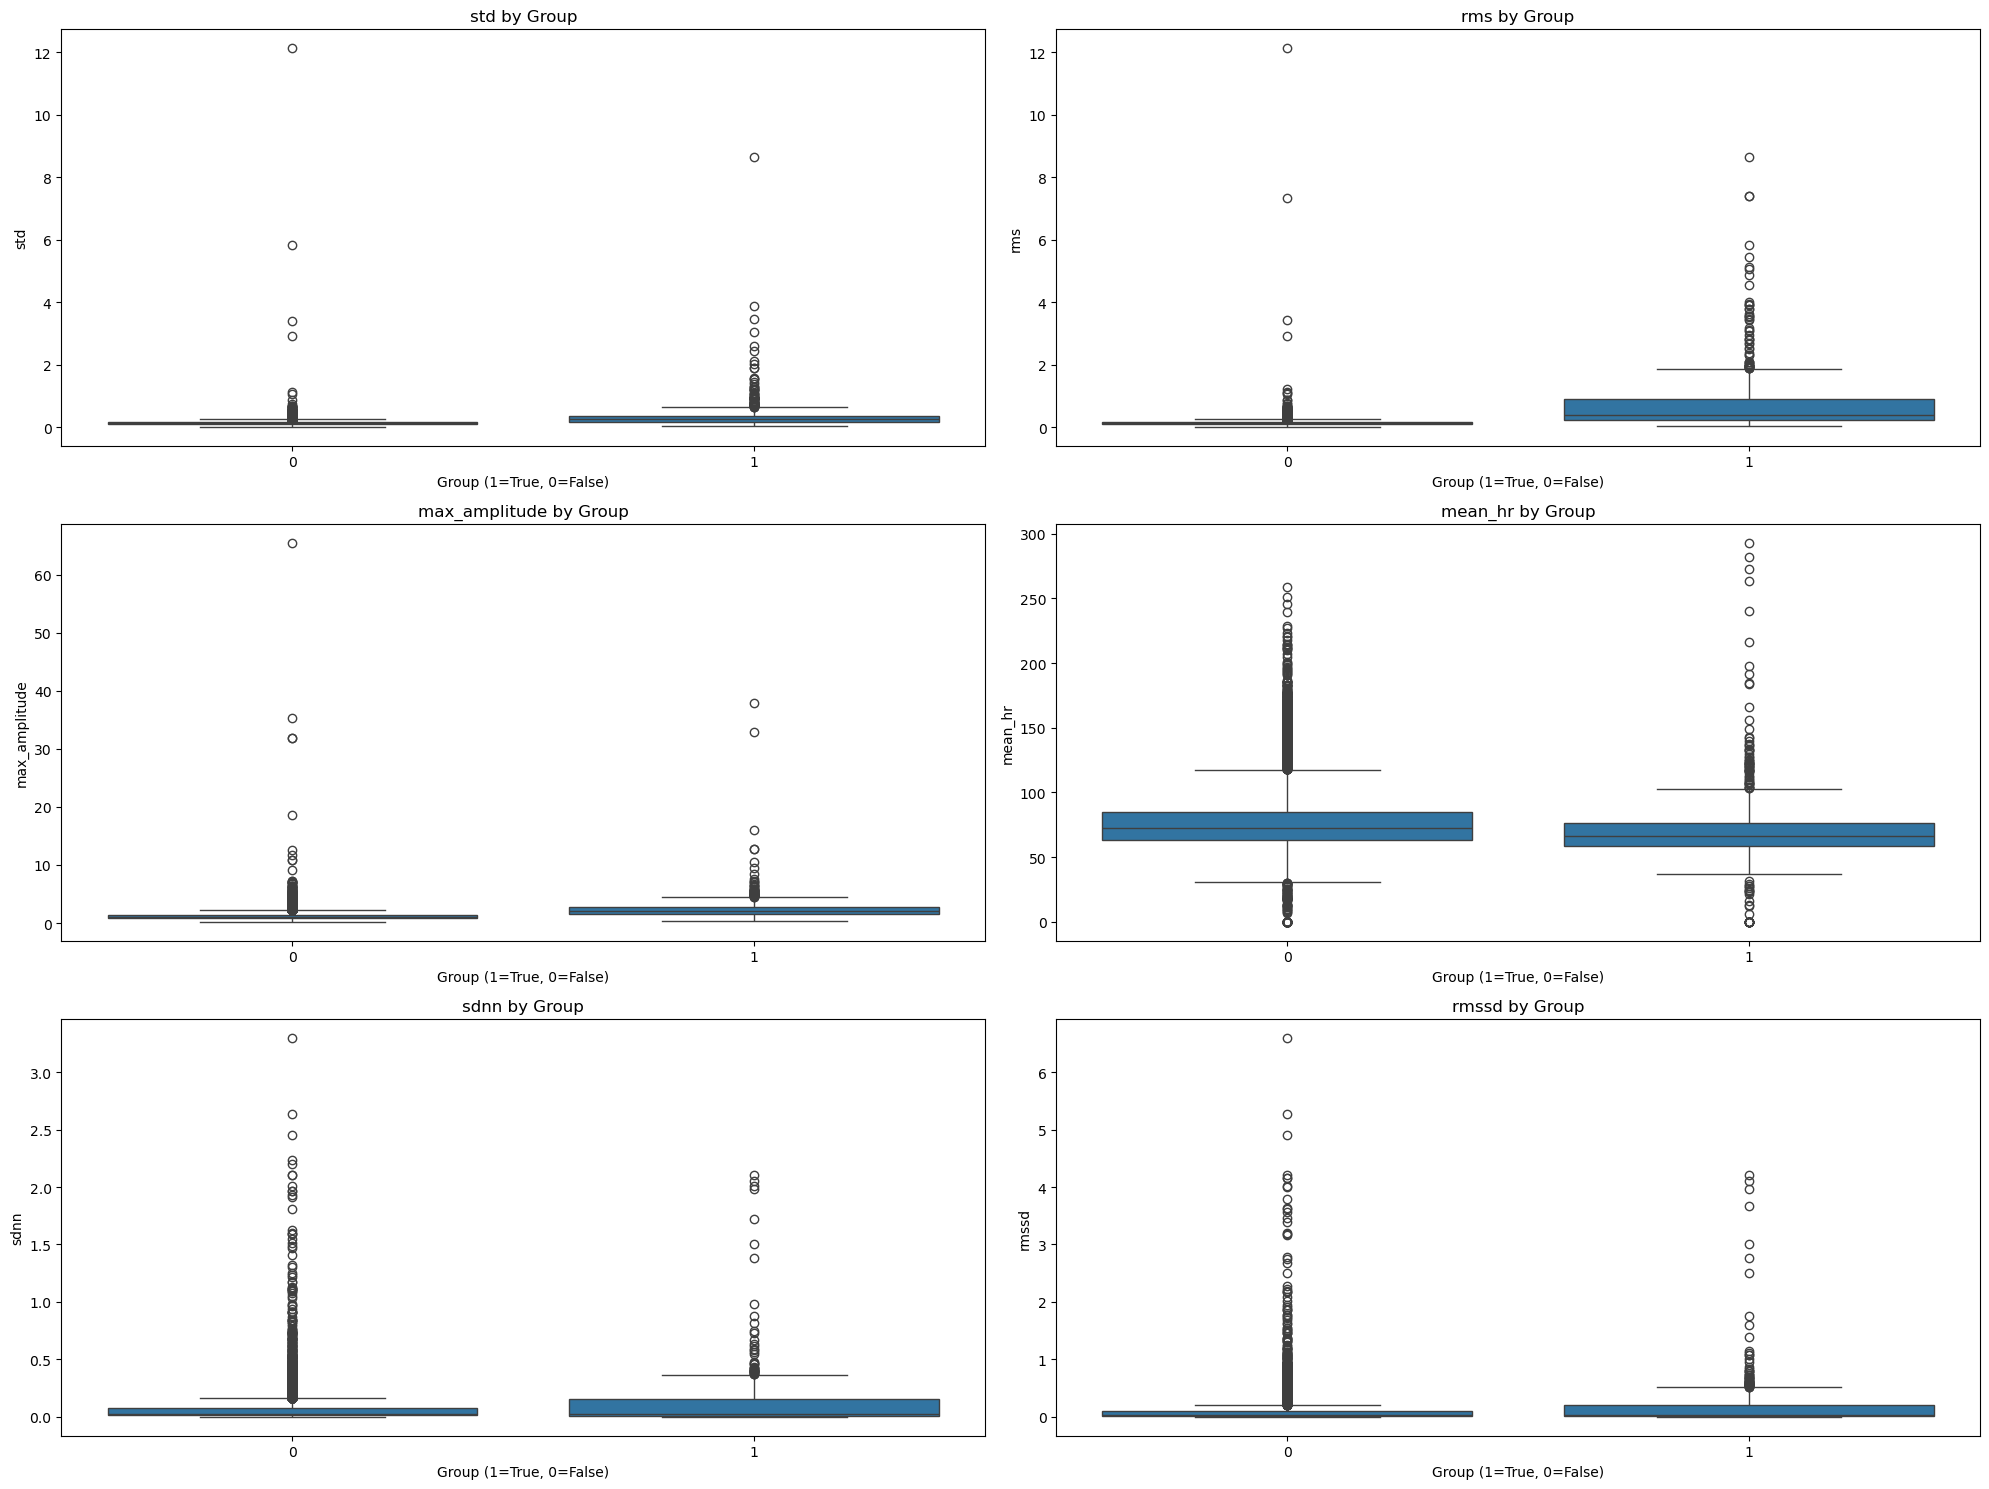

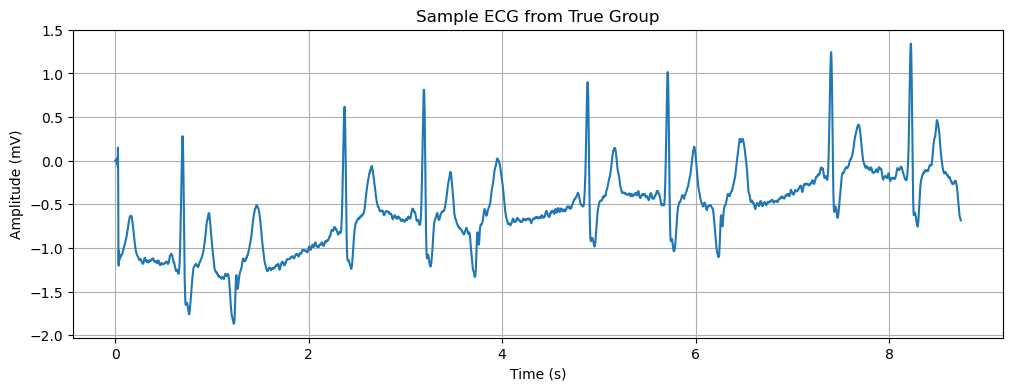

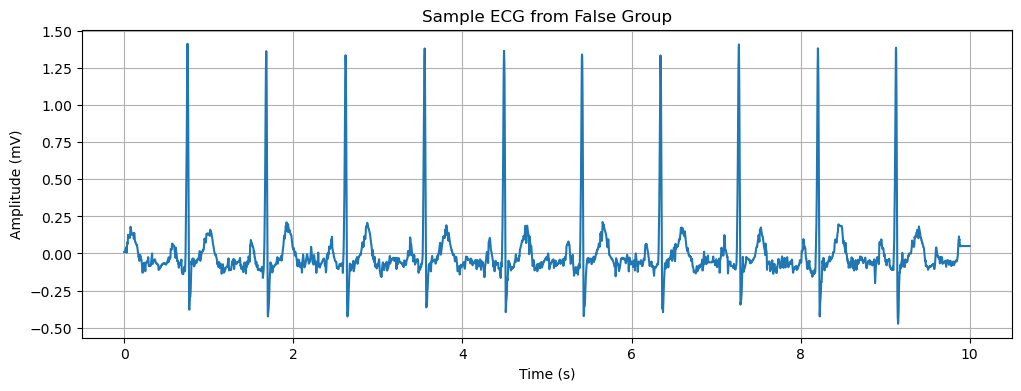

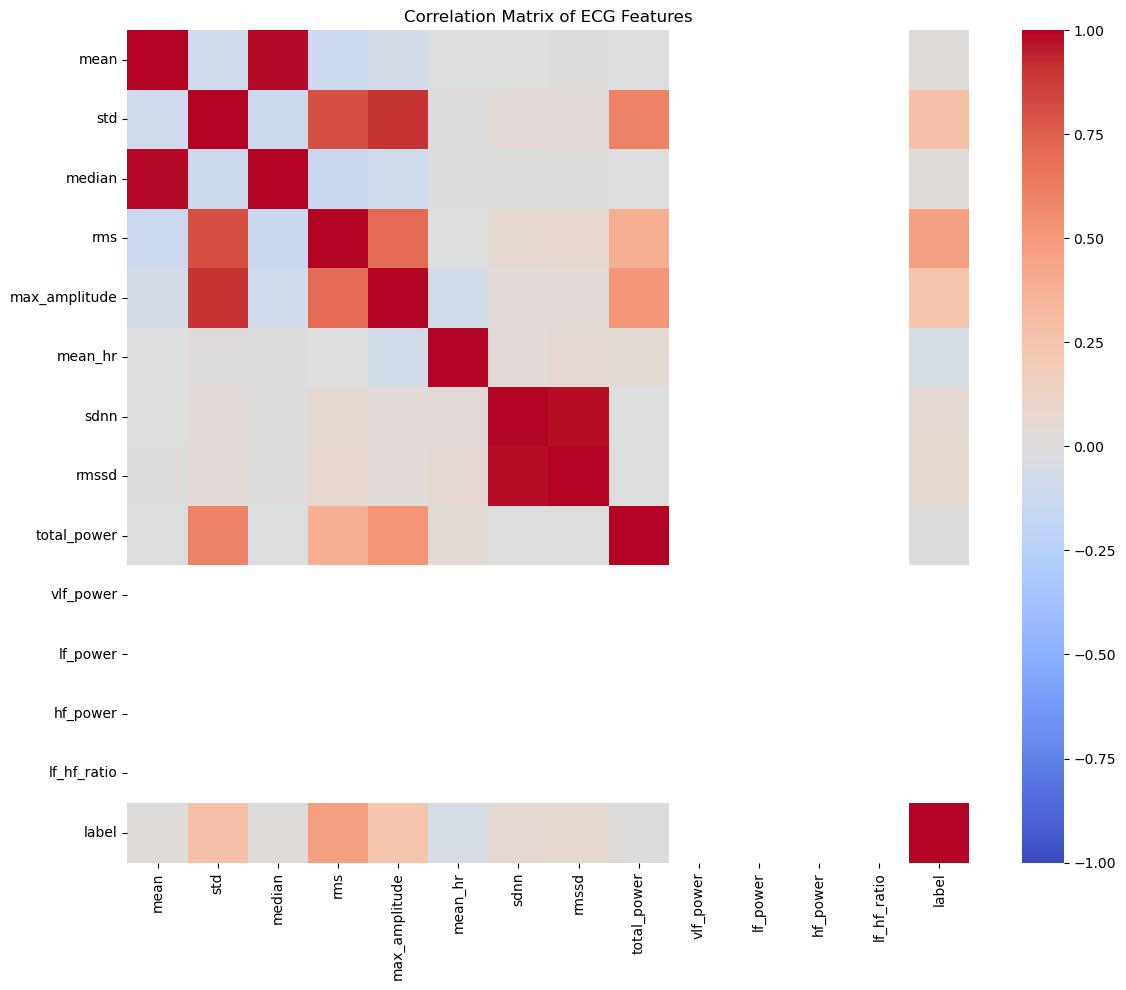

Features saved to ecg_features.csv


In [4]:
# Extract ECG features
def extract_ecg_features(record_path):
    """Extract features from an ECG record"""
    try:
        # Read the record data
        record = wfdb.rdrecord(record_path)
        signals = record.p_signal
        fs = record.fs  # Sampling frequency
        
        # Initialize feature dictionary
        features = {}
        
        # Process each lead (if multi-lead)
        num_leads = signals.shape[1] if len(signals.shape) > 1 else 1
        
        # Get signal from the first lead for simplicity if multiple leads exist
        ecg_signal = signals[:, 0] if num_leads > 1 else signals
        
        # Basic signal statistics
        features['mean'] = np.mean(ecg_signal)
        features['std'] = np.std(ecg_signal)
        features['median'] = np.median(ecg_signal)
        features['rms'] = np.sqrt(np.mean(ecg_signal**2))
        features['max_amplitude'] = np.max(ecg_signal) - np.min(ecg_signal)
        
        # Apply bandpass filter to remove noise
        lowcut = 0.5  # Hz
        highcut = 50.0  # Hz
        b, a = signal.butter(3, [lowcut/(fs/2), highcut/(fs/2)], 'band')
        filtered_signal = signal.filtfilt(b, a, ecg_signal)
        
        # Detect R-peaks
        rpeaks, _ = signal.find_peaks(filtered_signal, height=0.5*np.max(filtered_signal), distance=int(0.2*fs))
        
        # Heart rate variability features
        if len(rpeaks) > 1:
            # Calculate RR intervals (in seconds)
            rr_intervals = np.diff(rpeaks) / fs
            features['mean_hr'] = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
            features['sdnn'] = np.std(rr_intervals) if len(rr_intervals) > 0 else 0
            features['rmssd'] = np.sqrt(np.mean(np.square(np.diff(rr_intervals)))) if len(rr_intervals) > 1 else 0
        else:
            features['mean_hr'] = 0
            features['sdnn'] = 0
            features['rmssd'] = 0
        
        # Frequency domain features
        if len(ecg_signal) > 10:  # Simple check to ensure signal has enough data
            # Power spectral density
            f, psd = signal.welch(ecg_signal, fs, nperseg=256)
            # Total power
            features['total_power'] = np.sum(psd)
            # Power in different bands
            vlf_indices = np.logical_and(f >= 0.003, f < 0.04)
            lf_indices = np.logical_and(f >= 0.04, f < 0.15)
            hf_indices = np.logical_and(f >= 0.15, f < 0.4)
            features['vlf_power'] = np.sum(psd[vlf_indices]) if np.any(vlf_indices) else 0
            features['lf_power'] = np.sum(psd[lf_indices]) if np.any(lf_indices) else 0
            features['hf_power'] = np.sum(psd[hf_indices]) if np.any(hf_indices) else 0
            features['lf_hf_ratio'] = features['lf_power'] / features['hf_power'] if features['hf_power'] > 0 else 0
        else:
            features['total_power'] = 0
            features['vlf_power'] = 0
            features['lf_power'] = 0
            features['hf_power'] = 0
            features['lf_hf_ratio'] = 0
            
        return features
        
    except Exception as e:
        print(f"Error processing {record_path}: {e}")
        return None

# Extract features from both datasets
def extract_features_from_records(record_paths, label):
    all_features = []
    for record_path in tqdm(record_paths, desc=f"Processing {label} records"):
        features = extract_ecg_features(record_path)
        if features:
            features['label'] = label
            features['record_id'] = os.path.basename(record_path)
            all_features.append(features)
    return all_features

# Extract features
samitrop_features = extract_features_from_records(samitrop_records, label=1)  # True class
ptbxl_features = extract_features_from_records(ptbxl_records, label=0)        # False class

# Combine into a single dataframe
all_features = samitrop_features + ptbxl_features
features_df = pd.DataFrame(all_features)

# Show the data
features_df.head()

# Basic summary statistics by group
summary_stats = features_df.groupby('label').describe()
print("Summary statistics by group (1=True, 0=False):")
summary_stats

# Perform t-tests for each feature
def perform_statistical_tests(df, feature_cols):
    results = []
    for feature in feature_cols:
        try:
            # Get data for each group
            group1 = df[df['label'] == 1][feature].dropna()
            group0 = df[df['label'] == 0][feature].dropna()
            
            # Perform t-test
            t_stat, p_value = ttest_ind(group1, group0, equal_var=False)
            
            # Calculate effect size (Cohen's d)
            mean1, mean0 = group1.mean(), group0.mean()
            std1, std0 = group1.std(), group0.std()
            pooled_std = np.sqrt(((len(group1) - 1) * std1**2 + (len(group0) - 1) * std0**2) / 
                              (len(group1) + len(group0) - 2))
            cohen_d = (mean1 - mean0) / pooled_std if pooled_std > 0 else 0
            
            results.append({
                'feature': feature,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'mean_true': mean1,
                'mean_false': mean0,
                'effect_size': cohen_d
            })
        except Exception as e:
            print(f"Error analyzing feature {feature}: {e}")
            
    return pd.DataFrame(results)

# Feature columns (excluding 'label' and 'record_id')
feature_cols = [col for col in features_df.columns if col not in ['label', 'record_id']]

# Run statistical tests
stats_results = perform_statistical_tests(features_df, feature_cols)

# Sort by p-value
stats_results_sorted = stats_results.sort_values('p_value')
stats_results_sorted

# Visualize the distribution of key features
plt.figure(figsize=(20, 15))

# Select top significant features or all features if few are available
significant_features = stats_results[stats_results['significant']]['feature'].tolist()
features_to_plot = significant_features[:6] if len(significant_features) > 6 else significant_features

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='label', y=feature, data=features_df)
    plt.title(f'{feature} by Group')
    plt.xlabel('Group (1=True, 0=False)')

plt.tight_layout()
plt.show()

# Plot sample ECGs
def plot_sample_ecg(record_path, title):
    try:
        record = wfdb.rdrecord(record_path)
        signals = record.p_signal
        fs = record.fs
        time = np.arange(len(signals)) / fs
        
        plt.figure(figsize=(12, 4))
        if len(signals.shape) > 1:
            plt.plot(time, signals[:, 0])
        else:
            plt.plot(time, signals)
            
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error plotting {record_path}: {e}")

# Plot a sample from each group
if len(samitrop_records) > 0:
    plot_sample_ecg(samitrop_records[0], 'Sample ECG from True Group')

if len(ptbxl_records) > 0:
    plot_sample_ecg(ptbxl_records[0], 'Sample ECG from False Group')

# Correlation matrix of features
numeric_columns = features_df.select_dtypes(include=[np.number]).columns
correlation_matrix = features_df[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of ECG Features')
plt.tight_layout()
plt.show()

# Save the features dataframe to CSV
features_df.to_csv('ecg_features.csv', index=False)
print("Features saved to ecg_features.csv")

In [6]:
import os
import wfdb
import neurokit2 as nk
import pandas as pd

# Paths to your folders
samitropTrue_directory_path = os.path.expanduser('~/project/data/samitropTrue')
ptbXLFalse_directory_path  = os.path.expanduser('~/project/data/ptbxlFalse')

def extract_ecg_features(record_path):
    """
    Given the WFDB record base (without .dat/.hea), read channel 0,
    clean it, detect peaks/delineate waves, and return summary features.
    """
    # Load the record (gives .p_signal and .fs)
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # first channel
    fs     = record.fs              # sampling rate

    # 1) Clean / filter the raw ECG
    ecg_clean = nk.ecg_clean(signal, sampling_rate=fs)

    # 2) Find R-peaks & related events
    peaks, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)

    # 3) Delineate P- and QRS-complex
    delineation, _ = nk.ecg_delineate(
        ecg_clean,
        peaks,
        sampling_rate=fs,
        method="dwt"
    )

    # 4) Compute durations (seconds) and amplitudes (µV or raw units)
    p_durations   = (delineation["ECG_P_Offsets"] - delineation["ECG_P_Onsets"]) / fs
    qrs_durations = (delineation["ECG_R_Offsets"] - delineation["ECG_R_Onsets"]) / fs

    p_amplitudes  = ecg_clean[delineation["ECG_P_Peaks"]]
    r_amplitudes  = ecg_clean[delineation["ECG_R_Peaks"]]

    return {
        "mean_p_duration_s":   p_durations.mean(),
        "mean_qrs_duration_s": qrs_durations.mean(),
        "mean_p_amplitude":    p_amplitudes.mean(),
        "mean_r_amplitude":    r_amplitudes.mean(),
        "n_beats":             len(info["ECG_R_Peaks"]),
    }

In [14]:
#!/usr/bin/env python3

import os
import wfdb
import neurokit2 as nk
import pandas as pd
import numpy as np
import traceback

# ── Your data folders ─────────────────────────────────────────────────────────
samitropTrue_directory_path = os.path.expanduser('~/project/data/samitropTrue')
ptbXLFalse_directory_path  = os.path.expanduser('~/project/data/ptbxlFalse')

# ── Helper to clean and cast peaks, dropping NaNs ─────────────────────────────
def clean_peaks(raw_list):
    return np.array([int(x) for x in raw_list if not pd.isna(x)], dtype=int)

# ── Feature‐extraction function ────────────────────────────────────────────────
def extract_ecg_features(record_base):
    signals, fields = wfdb.rdsamp(record_base)
    signal = signals[:, 0]
    fs     = float(fields.get("fs", 500))

    ecg_clean = nk.ecg_clean(signal, sampling_rate=fs)

    peaks_df, info_peaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = clean_peaks(info_peaks.get("ECG_R_Peaks", []))
    if rpeaks.size == 0:
        raise ValueError("No R-peaks found")

    _, deline_info = nk.ecg_delineate(
        ecg_clean, rpeaks, sampling_rate=fs, method="dwt"
    )

    # Clean & cast all indices
    p_onsets  = clean_peaks(deline_info.get("ECG_P_Onsets", []))
    p_offsets = clean_peaks(deline_info.get("ECG_P_Offsets", []))
    p_peaks   = clean_peaks(deline_info.get("ECG_P_Peaks", []))

    q_peaks   = clean_peaks(deline_info.get("ECG_Q_Peaks", []))
    s_peaks   = clean_peaks(deline_info.get("ECG_S_Peaks", []))

    # Pair up onsets/offsets using zip to avoid shape mismatches
    p_durs = np.array([(off - on) for on, off in zip(p_onsets, p_offsets)], dtype=float) / fs
    qrs_durs = np.array([(off - on) for on, off in zip(q_peaks, s_peaks)],   dtype=float) / fs

    if p_durs.size == 0:
        raise ValueError("P-wave durations could not be computed")
    if qrs_durs.size == 0:
        raise ValueError("QRS durations could not be computed")

    # Amplitudes can be taken directly
    p_amps = ecg_clean[p_peaks] if p_peaks.size else np.array([])
    r_amps = ecg_clean[rpeaks]

    return {
        "mean_p_duration_s":   p_durs.mean(),
        "mean_qrs_duration_s": qrs_durs.mean(),
        "mean_p_amplitude":    p_amps.mean() if p_amps.size else np.nan,
        "mean_r_amplitude":    r_amps.mean(),
        "n_beats":             rpeaks.size,
    }

# ── Batch‐process all records ──────────────────────────────────────────────────
all_results = []

for label, folder in [
    ("true",  samitropTrue_directory_path),
    ("false", ptbXLFalse_directory_path)
]:
    for fname in os.listdir(folder):
        base, ext = os.path.splitext(fname)
        if ext.lower() != ".dat":
            continue

        record_base = os.path.join(folder, base)
        try:
            feats = extract_ecg_features(record_base)
            feats.update(record=fname, label=label)
            all_results.append(feats)

        except Exception as e:
            print(f"⚠️ Skipping {fname} — {type(e).__name__}: {e}")
            traceback.print_exc()

# ── Save results ───────────────────────────────────────────────────────────────
df = pd.DataFrame(all_results)
print(df)
df.to_csv("ecg_features.csv", index=False)
print("✅ Saved ecg_features.csv")


⚠️ Skipping 364889.dat — ValueError: The data length is too small to be segmented.


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 31, in extract_ecg_features
    _, deline_info = nk.ecg_delineate(
                     ^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 164, in ecg_delineate
    waves = _dwt_ecg_delineator(ecg_cleaned, rpeaks, sampling_rate=sampling_rate)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 252, in _dwt_ecg_delineator
    heartbeats = ecg_segment(ecg, rpeaks, sampling_rate=sampling_rate)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_segment

⚠️ Skipping 465998.dat — ValueError: The data length is too small to be segmented.


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 31, in extract_ecg_features
    _, deline_info = nk.ecg_delineate(
                     ^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 164, in ecg_delineate
    waves = _dwt_ecg_delineator(ecg_cleaned, rpeaks, sampling_rate=sampling_rate)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 252, in _dwt_ecg_delineator
    heartbeats = ecg_segment(ecg, rpeaks, sampling_rate=sampling_rate)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_segment

⚠️ Skipping 406936.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 117986.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 372389.dat — ValueError: The data length is too small to be segmented.


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 31, in extract_ecg_features
    _, deline_info = nk.ecg_delineate(
                     ^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 164, in ecg_delineate
    waves = _dwt_ecg_delineator(ecg_cleaned, rpeaks, sampling_rate=sampling_rate)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 252, in _dwt_ecg_delineator
    heartbeats = ecg_segment(ecg, rpeaks, sampling_rate=sampling_rate)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_segment

⚠️ Skipping 443647.dat — ValueError: No R-peaks found


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 29, in extract_ecg_features
    raise ValueError("No R-peaks found")
ValueError: No R-peaks found


⚠️ Skipping 355698.dat — ValueError: The data length is too small to be segmented.


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 31, in extract_ecg_features
    _, deline_info = nk.ecg_delineate(
                     ^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 164, in ecg_delineate
    waves = _dwt_ecg_delineator(ecg_cleaned, rpeaks, sampling_rate=sampling_rate)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_delineate.py", line 252, in _dwt_ecg_delineator
    heartbeats = ecg_segment(ecg, rpeaks, sampling_rate=sampling_rate)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg_segment

⚠️ Skipping 02145_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 15822_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 16762_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 05293_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 10053_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 17164_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 15812_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 09823_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 03134_hr.dat — ValueError: P-wave durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 48, in extract_ecg_features
    raise ValueError("P-wave durations could not be computed")
ValueError: P-wave durations could not be computed


⚠️ Skipping 03772_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 18960_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 12464_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 14887_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 10306_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 21621_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 12000_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 12993_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 21171_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 19428_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 11035_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 07960_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 03087_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 09395_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 02602_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 06240_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 06704_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 08060_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 14881_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 18596_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 10869_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 21288_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 03905_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 06892_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed
/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 31, in extract_ecg_features
    _, deline_info = nk.ecg_delineate(
                     ^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg

⚠️ Skipping 20592_hr.dat — ValueError: cannot convert float NaN to integer
⚠️ Skipping 07866_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 16845_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 03267_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed
/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 31, in extract_ecg_features
    _, deline_info = nk.ecg_delineate(
                     ^^^^^^^^^^^^^^^^^
  File "/home/physionet/miniconda3/lib/python3.12/site-packages/neurokit2/ecg/ecg

⚠️ Skipping 20830_hr.dat — ValueError: cannot convert float NaN to integer
⚠️ Skipping 09371_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 15167_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 10399_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 07159_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


⚠️ Skipping 01006_hr.dat — ValueError: QRS durations could not be computed


Traceback (most recent call last):
  File "/tmp/ipykernel_2153742/256490225.py", line 78, in <module>
    feats = extract_ecg_features(record_base)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2153742/256490225.py", line 50, in extract_ecg_features
    raise ValueError("QRS durations could not be computed")
ValueError: QRS durations could not be computed


       mean_p_duration_s  mean_qrs_duration_s  mean_p_amplitude  \
0               0.062500            -5.450000         -0.038291   
1               0.112750             0.071667          0.016363   
2               0.104250             0.100000          0.004567   
3               0.078636             0.148750          0.095214   
4              -0.922500             0.097500          0.021600   
...                  ...                  ...               ...   
22559           0.098000             0.066200          0.039572   
22560           0.042000             0.314364          0.565079   
22561           0.090727             0.321400          0.077104   
22562           0.085273             0.070800          0.039163   
22563           0.109167             0.099091          0.063543   

       mean_r_amplitude  n_beats        record  label  
0              1.810996       10    360938.dat   true  
1              0.556043       10    452878.dat   true  
2              1.220041    

In [16]:
import pandas as pd

# 1) Load your data
df = pd.read_csv("ecg_features.csv")

# 2) Define your features and IQR function
features = [
    "mean_p_duration_s",
    "mean_qrs_duration_s",
    "mean_p_amplitude",
    "mean_r_amplitude",
    "n_beats",
]

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

# 3) Group & aggregate
summary = (
    df
    .groupby("label")[features]
    .agg(["count", "mean", "std", "median", iqr])
)

# 4) Flatten the MultiIndex columns
summary.columns = [
    f"{feat}_{stat if stat != '<lambda>' else 'iqr'}"
    for feat, stat in summary.columns
]

print(summary)


       mean_p_duration_s_count  mean_p_duration_s_mean  mean_p_duration_s_std  \
label                                                                           
False                    21756                0.023659               0.225408   
True                       808                0.020680               0.239643   

       mean_p_duration_s_median  mean_p_duration_s_iqr  \
label                                                    
False                  0.083167               0.028583   
True                   0.080732               0.033027   

       mean_qrs_duration_s_count  mean_qrs_duration_s_mean  \
label                                                        
False                      21756                  0.026246   
True                         808                  0.025532   

       mean_qrs_duration_s_std  mean_qrs_duration_s_median  \
label                                                        
False                 0.466154                    0.106000   
True   

In [18]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

# 1) Reload and inspect
df = pd.read_csv("ecg_features.csv")
features = [
    "mean_p_duration_s",
    "mean_qrs_duration_s",
    "mean_p_amplitude",
    "mean_r_amplitude",
    "n_beats",
]

# 2) How many records per label?
print(df.label.value_counts(), "\n")

# 3) Are there any missing or non-numeric values?
print(df[features].dtypes, "\n")
print("Nulls per feature:\n", df[features].isna().sum(), "\n")

# 4) Drop rows with any missing feature
df_clean = df.dropna(subset=features)

# 5) Re-check counts
print("After dropping NaNs:", df_clean.label.value_counts(), "\n")

# 6) Convert to numeric if needed
for feat in features:
    df_clean[feat] = pd.to_numeric(df_clean[feat], errors="coerce")

# 7) Final drop of any rows that couldn’t be converted
df_clean = df_clean.dropna(subset=features)

# 8) Inferential tests, only if both groups have ≥2 samples
results = []
for feat in features:
    a = df_clean.loc[df_clean.label=="true", feat]
    b = df_clean.loc[df_clean.label=="false", feat]
    if len(a) >= 2 and len(b) >= 2:
        t, p = ttest_ind(a, b, equal_var=False)
    else:
        t, p = np.nan, np.nan
    results.append({
        "feature": feat,
        "true_n":   len(a),
        "false_n":  len(b),
        "true_mean":  a.mean(),
        "false_mean": b.mean(),
        "t_stat":     t,
        "p_value":    p,
    })

res_df = pd.DataFrame(results)
print(res_df)


label
False    21756
True       808
Name: count, dtype: int64 

mean_p_duration_s      float64
mean_qrs_duration_s    float64
mean_p_amplitude       float64
mean_r_amplitude       float64
n_beats                  int64
dtype: object 

Nulls per feature:
 mean_p_duration_s      0
mean_qrs_duration_s    0
mean_p_amplitude       0
mean_r_amplitude       0
n_beats                0
dtype: int64 

After dropping NaNs: label
False    21756
True       808
Name: count, dtype: int64 

               feature  true_n  false_n  true_mean  false_mean  t_stat  \
0    mean_p_duration_s       0        0        NaN         NaN     NaN   
1  mean_qrs_duration_s       0        0        NaN         NaN     NaN   
2     mean_p_amplitude       0        0        NaN         NaN     NaN   
3     mean_r_amplitude       0        0        NaN         NaN     NaN   
4              n_beats       0        0        NaN         NaN     NaN   

   p_value  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [21]:
import pandas as pd

# assume df is already loaded and df["is_true"] exists

features = [
    "mean_p_duration_s",
    "mean_qrs_duration_s",
    "mean_p_amplitude",
    "mean_r_amplitude",
    "n_beats",
]

# 1. Descriptive statistics
descr = df.groupby("is_true")[features].agg([
    "count", "mean", "std", "median",
    lambda x: x.quantile(0.75) - x.quantile(0.25)
])

# 2. Flatten the column MultiIndex, renaming the lambda to 'iqr'
descr.columns = [
    f"{feat}_{stat if stat != '<lambda_0>' else 'iqr'}"
    for feat, stat in descr.columns
]

print("\n=== Descriptive Statistics by Label ===")
print(descr)



=== Descriptive Statistics by Label ===
         mean_p_duration_s_count  mean_p_duration_s_mean  \
is_true                                                    
False                      21756                0.023659   
True                         808                0.020680   

         mean_p_duration_s_std  mean_p_duration_s_median  \
is_true                                                    
False                 0.225408                  0.083167   
True                  0.239643                  0.080732   

         mean_p_duration_s_iqr  mean_qrs_duration_s_count  \
is_true                                                     
False                 0.028583                      21756   
True                  0.033027                        808   

         mean_qrs_duration_s_mean  mean_qrs_duration_s_std  \
is_true                                                      
False                    0.026246                 0.466154   
True                     0.025532             

In [22]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

results = []
for feat in features:
    a = df.loc[df.is_true, feat]
    b = df.loc[~df.is_true, feat]

    # Welch's t-test + Cohen's d
    if len(a) >= 2 and len(b) >= 2:
        t_stat, p_t = ttest_ind(a, b, equal_var=False, nan_policy="omit")
        d = (a.mean() - b.mean()) / np.sqrt((a.std()**2 + b.std()**2)/2)
    else:
        t_stat = p_t = d = np.nan

    # Mann–Whitney U
    if len(a) >= 1 and len(b) >= 1:
        _, p_mw = mannwhitneyu(a, b, alternative="two-sided")
    else:
        p_mw = np.nan

    results.append({
        "feature":    feat,
        "n_true":     len(a),
        "n_false":    len(b),
        "mean_true":  a.mean(),
        "mean_false": b.mean(),
        "t_stat":     t_stat,
        "p_value_t":  p_t,
        "cohen_d":    d,
        "p_value_mw": p_mw,
    })

res_df = pd.DataFrame(results)
print("\n=== Inferential Statistics ===")
print(res_df)



=== Inferential Statistics ===
               feature  n_true  n_false  mean_true  mean_false     t_stat  \
0    mean_p_duration_s     808    21756   0.020680    0.023659  -0.347681   
1  mean_qrs_duration_s     808    21756   0.025532    0.026246  -0.033538   
2     mean_p_amplitude     808    21756   0.059605    0.027665   5.959675   
3     mean_r_amplitude     808    21756   0.827231    0.539484  16.864862   
4              n_beats     808    21756   9.537129   12.057639 -27.816088   

       p_value_t   cohen_d     p_value_mw  
0   7.281647e-01 -0.012805   2.080891e-02  
1   9.732537e-01 -0.001331   7.640662e-01  
2   3.767392e-09  0.288046   9.014272e-53  
3   4.685089e-55  0.739576   4.999261e-77  
4  2.039515e-122 -0.980349  7.215605e-145  


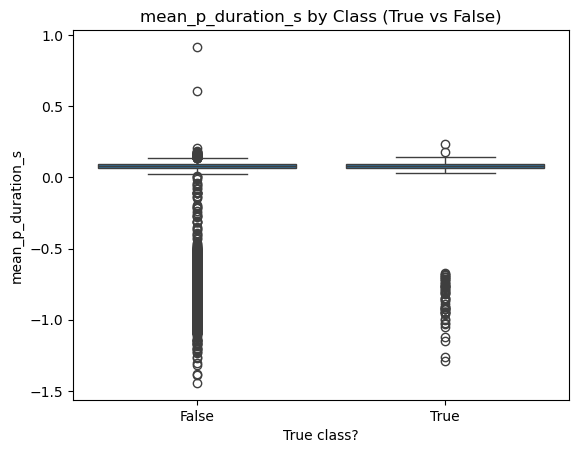

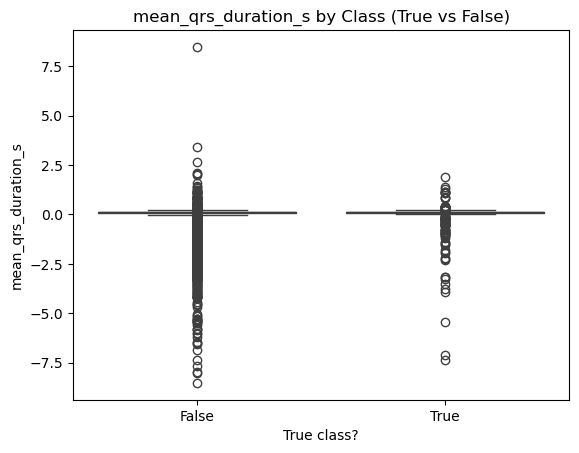

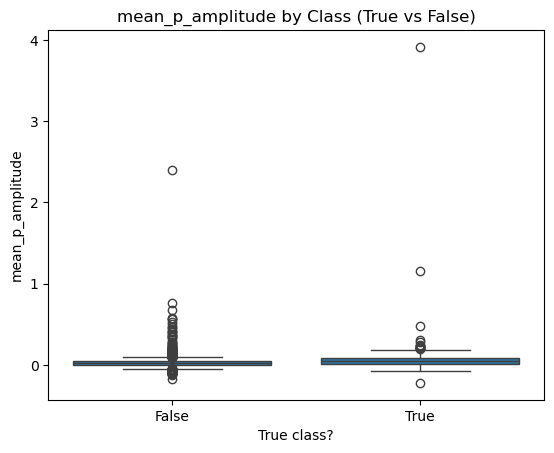

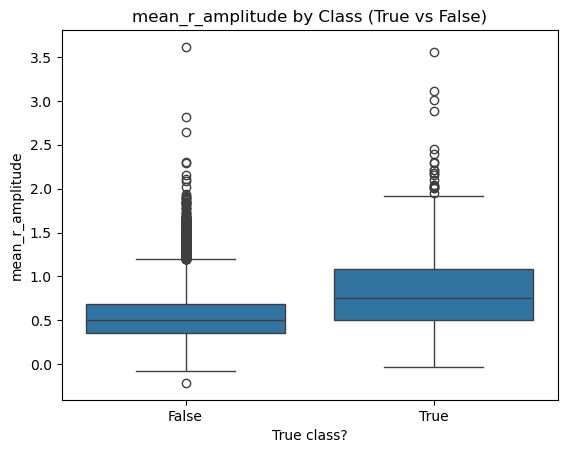

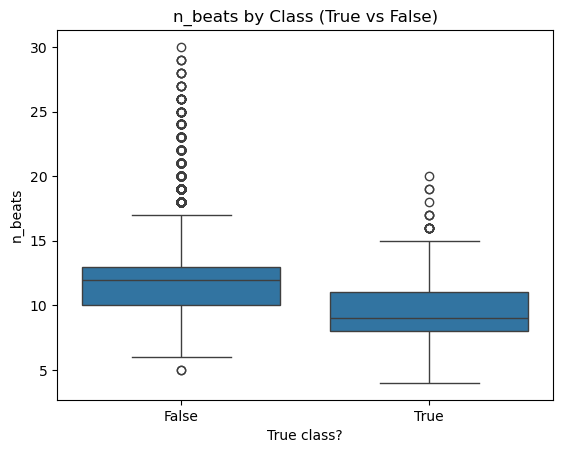

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

for feat in features:
    plt.figure()
    sns.boxplot(x="is_true", y=feat, data=df)
    plt.title(f"{feat} by Class (True vs False)")
    plt.xlabel("True class?")
    plt.ylabel(feat)
    plt.show()


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1) Load the data
df = pd.read_csv("ecg_features.csv")

# 2) Define X (features) and y (binary target)
X = df[["mean_p_amplitude", "mean_r_amplitude", "n_beats"]]
y = df["label"].astype(bool)   # True / False

# 3) Split into train/test (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Standardize (mean=0, std=1) on training set, apply to test set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5) Instantiate and train a logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# 6) Evaluate on test set
y_pred = model.predict(X_test_scaled)
acc    = accuracy_score(y_test, y_pred)

print("Test Accuracy: {:.2%}".format(acc))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["False(True=0)","True(=1)"],
    columns=["Pred 0","Pred 1"]
))

# 7) (Optional) 5-fold cross-validation accuracy
cv_scores = cross_val_score(
    model,
    scaler.transform(X),  # or fit inside pipeline
    y,
    cv=5,
    scoring="accuracy"
)
print("\n5-Fold CV Accuracy: {:.2%} ± {:.2%}".format(
    cv_scores.mean(), cv_scores.std()
))


Test Accuracy: 96.72%

Classification Report:
              precision    recall  f1-score   support

       False     0.9688    0.9982    0.9832      4351
        True     0.7333    0.1358    0.2292       162

    accuracy                         0.9672      4513
   macro avg     0.8511    0.5670    0.6062      4513
weighted avg     0.9603    0.9672    0.9562      4513

Confusion Matrix:
               Pred 0  Pred 1
False(True=0)    4343       8
True(=1)          140      22

5-Fold CV Accuracy: 96.68% ± 0.10%


In [32]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing    import StandardScaler
from sklearn.ensemble         import RandomForestClassifier
from sklearn.metrics          import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# 1) Load and prepare
df = pd.read_csv("ecg_features.csv")
X = df[["mean_p_amplitude", "mean_r_amplitude", "n_beats"]]
y = df["label"].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 2) Random Forest with class_weight='balanced'
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# (Optional) quick grid search on max_depth / min_samples_leaf
param_grid = {
    "max_depth":        [None, 5, 10],
    "min_samples_leaf": [1, 5, 10],
}
gs = GridSearchCV(rf, param_grid, cv=3, scoring="f1", n_jobs=-1)
gs.fit(X_train_s, y_train)
best = gs.best_estimator_

# 3) Evaluate
y_pred = best.predict(X_test_s)
y_proba = best.predict_proba(X_test_s)[:,1]

print("Best params:", gs.best_params_)
print("Test Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Test AUC-ROC:   {:.3f}".format(roc_auc_score(y_test, y_proba)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", pd.DataFrame(
    cm,
    index=["Actual False","Actual True"],
    columns=["Pred False","Pred True"]
))

pth = np.percentile(y_proba, 97)

# 2) select only the test‐rows whose prob ≥ that threshold
mask_top5 = (y_proba >= pth)

# 3) build “predictions” on that subset as all True
y_true_top5 = y_test.values[mask_top5]
y_pred_top5 = np.ones_like(y_true_top5, dtype=bool)

# 4) compute confusion metrics on that slice
print(f"Selected {mask_top5.sum()} samples (top 5%) out of {len(y_test)}\n")
print("Classification report on top 5%:")
print(classification_report(y_true_top5, y_pred_top5, digits=4))
print("Confusion matrix on top 5%:")
print(confusion_matrix(y_true_top5, y_pred_top5))


Best params: {'max_depth': None, 'min_samples_leaf': 5}
Test Accuracy: 95.79%
Test AUC-ROC:   0.854

Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.97      0.98      4351
        True       0.43      0.50      0.46       162

    accuracy                           0.96      4513
   macro avg       0.70      0.74      0.72      4513
weighted avg       0.96      0.96      0.96      4513

Confusion Matrix:
               Pred False  Pred True
Actual False        4242        109
Actual True           81         81
Selected 136 samples (top 5%) out of 4513

Classification report on top 5%:
              precision    recall  f1-score   support

       False     0.0000    0.0000    0.0000        64
        True     0.5294    1.0000    0.6923        72

    accuracy                         0.5294       136
   macro avg     0.2647    0.5000    0.3462       136
weighted avg     0.2803    0.5294    0.3665       136

Confusion matrix o

/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) Locate & load your features CSV (adjust path as needed)
paths = glob.glob('**/ecg_features.csv', recursive=True)
if not paths:
    raise FileNotFoundError("Could not find 'ecg_features.csv'")
df = pd.read_csv(paths[0])

# 2) Prepare data
X = df[["mean_p_amplitude", "mean_r_amplitude", "n_beats"]]
y = df["label"].astype(bool)

# 3) Set up 5-fold stratified CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aggregate_cm = np.zeros((2, 2), dtype=int)

# 4) Loop over folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 4a) Scale features
    scaler = StandardScaler().fit(X_train)
    X_train_s, X_val_s = scaler.transform(X_train), scaler.transform(X_val)

    # 4b) Train a Balanced Random Forest
    clf = RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    )
    clf.fit(X_train_s, y_train)

    # 4c) Predict probabilities on validation fold
    probs = clf.predict_proba(X_val_s)[:, 1]

    # 4d) Compute the 95th-percentile threshold
    thresh = np.percentile(probs, 95)

    # 4e) Select top 5%
    mask = probs >= thresh
    y_true_top = y_val.values[mask]
    y_pred_top = np.ones_like(y_true_top, dtype=bool)

    # 4f) Evaluate only on that subset
    print(f"\n--- Fold {fold} (threshold = {thresh:.4f}) ---")
    print(f"Selected {mask.sum()} / {len(y_val)} samples")
    print(classification_report(y_true_top, y_pred_top, digits=4))

    # Accumulate confusion matrix
    cm = confusion_matrix(y_true_top, y_pred_top, labels=[False, True])
    aggregate_cm += cm

# 5) Show aggregated confusion matrix across all folds
print("\nAggregated Confusion Matrix:")
print(pd.DataFrame(
    aggregate_cm,
    index=["Actual False","Actual True"],
    columns=["Pred False","Pred True"]
))



--- Fold 1 (threshold = 0.1650) ---
Selected 230 / 4513 samples
              precision    recall  f1-score   support

       False     0.0000    0.0000    0.0000       157
        True     0.3174    1.0000    0.4818        73

    accuracy                         0.3174       230
   macro avg     0.1587    0.5000    0.2409       230
weighted avg     0.1007    0.3174    0.1529       230



/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Fold 2 (threshold = 0.1750) ---
Selected 227 / 4513 samples
              precision    recall  f1-score   support

       False     0.0000    0.0000    0.0000       150
        True     0.3392    1.0000    0.5066        77

    accuracy                         0.3392       227
   macro avg     0.1696    0.5000    0.2533       227
weighted avg     0.1151    0.3392    0.1718       227



/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Fold 3 (threshold = 0.1950) ---
Selected 232 / 4513 samples
              precision    recall  f1-score   support

       False     0.0000    0.0000    0.0000       167
        True     0.2802    1.0000    0.4377        65

    accuracy                         0.2802       232
   macro avg     0.1401    0.5000    0.2189       232
weighted avg     0.0785    0.2802    0.1226       232



/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Fold 4 (threshold = 0.1800) ---
Selected 228 / 4513 samples
              precision    recall  f1-score   support

       False     0.0000    0.0000    0.0000       164
        True     0.2807    1.0000    0.4384        64

    accuracy                         0.2807       228
   macro avg     0.1404    0.5000    0.2192       228
weighted avg     0.0788    0.2807    0.1230       228



/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Fold 5 (threshold = 0.1650) ---
Selected 228 / 4512 samples
              precision    recall  f1-score   support

       False     0.0000    0.0000    0.0000       155
        True     0.3202    1.0000    0.4850        73

    accuracy                         0.3202       228
   macro avg     0.1601    0.5000    0.2425       228
weighted avg     0.1025    0.3202    0.1553       228


Aggregated Confusion Matrix:
              Pred False  Pred True
Actual False           0        793
Actual True            0        352


/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/physionet/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
from sklearn.svm      import SVC
from sklearn.pipeline import make_pipeline

# 1) Reuse X_train_s, y_train, X_test_s, y_test

# 2) Pipeline: StandardScaler → SVM
svm = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=42)
)
svm.fit(X_train, y_train)   # Note: scaler inside pipeline

# 3) Evaluate
y_pred_svm = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


Accuracy: 0.8637270108575227
              precision    recall  f1-score   support

       False     0.9887    0.8685    0.9248      4351
        True     0.1722    0.7346    0.2790       162

    accuracy                         0.8637      4513
   macro avg     0.5805    0.8016    0.6019      4513
weighted avg     0.9594    0.8637    0.9016      4513

Confusion Matrix:
 [[3779  572]
 [  43  119]]
